Importing required libraries to predict acceleration using random forest, calculate RMSE (RootMeanSquaredError), and create plots to compare predicted and actual acceleration

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore")
import pyreadr
import random
from sklearn.preprocessing import OneHotEncoder
import FileProcessing
import RandomForest

Loading the cleaned ngsim data using pandas

In [4]:
fileProcessing=FileProcessing.FileProcessing()
randomForest=RandomForest.RandomForest()

In [5]:
file_name='Cleaned_NGSIM_Data'
ngsim=fileProcessing.read_input(file_name)


original File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\scripts
Data File path: c:\Users\neels\Desktop\Capstone\carfollowing\DataDrivenCarFollowing\datadrivencarfollowing-v1\data


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\neels\\Desktop\\Capstone\\carfollowing\\DataDrivenCarFollowing\\datadrivencarfollowing-v1\\data/Cleaned_NGSIM_Data.csv'

Adding new columns nextframe acceleration, velocity, and position which will be our target features.

In [6]:
ngsim["nextframeAcc"]=ngsim.groupby(["L-F_Pair"],as_index=False)["v_Acc"].shift(-1)
ngsim["nextframesvel"]=ngsim.groupby(["L-F_Pair"],as_index=False)["v_Vel"].shift(-1)
ngsim["nextframeposition"]=ngsim.groupby(["L-F_Pair"],as_index=False)["Local_Y"].shift(-1)

Removing null values from added column as we have taken v_acc one step above in nextframeAcc in each pairs. 

In [7]:
ngsim = ngsim[ngsim["nextframeAcc"].notna()]

In [8]:

ngsim["Front_To_Rear_Time_Headway"] = ngsim["Front_To_Rear_Time_Headway"].replace(np.nan, 9999)

In [9]:
ngsim["Vehicle_combination_cat"] = ngsim["Vehicle_combination"].astype("category").cat.codes

Spliting data into 70% training and 30% testing

In [10]:
my_pairs=randomForest.createTrainPairs(ngsim)

In [11]:
#converting the total dataset to 70/30% pair for train and test. 
train = ngsim[ngsim['L-F_Pair'].isin(my_pairs)]

test = ngsim[~ngsim['L-F_Pair'].isin(my_pairs)]

In [12]:
#train = train.head(1000000)

In [13]:
#test = test.head(300000)

In [14]:
train.isnull().sum()

Vehicle_ID                                     0
Frame_ID                                       0
Global_Time                                    0
Local_X                                        0
Local_Y                                        0
Global_X                                       0
Global_Y                                       0
v_length                                       0
v_Class                                        0
v_Vel                                          0
v_Acc                                          0
Lane_ID                                        0
Preceding                                      0
Space_Headway                                  0
Time_Headway                                   0
Location                                       0
Preceding_Vehicle_Class                        0
Rear_to_Front_Space_Headway                    0
Front_To_Rear_Time_Headway                     0
Velocity Difference_Following-Preceding        0
Acceleration Differe

In [15]:
X_train = train[["Rear_to_Front_Space_Headway",'Vehicle_combination_cat','Local_Y','Velocity Difference_Following-Preceding','v_Vel']]
y_train= train['nextframeAcc']
X_test = test[["Rear_to_Front_Space_Headway",'Vehicle_combination_cat','Local_Y','Velocity Difference_Following-Preceding','v_Vel']]
y_test= test['nextframeAcc']
rf = RandomForestRegressor(n_estimators = 150,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

In [16]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['L-F_Pair'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['L-F_Pair']== i]
        vel=np.zeros(Q.shape[0])
        Vehicle_combination = np.zeros(Q.shape[0])
        Local_Y =  np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])

        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['v_Vel']
        spacing[0] = Q.iloc[0]['Rear_to_Front_Space_Headway']
        Vehicle_combination[0] = Q.iloc[0]['Vehicle_combination_cat']
        Local_Y[0] =  Q.iloc[0]['Local_Y']
        dv[0] = Q.iloc[0]['Velocity Difference_Following-Preceding']   
            
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],Vehicle_combination[0],Local_Y[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['previous_Vehicle_Velocity']
            #spacing[j] = spacing[j-1]+((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2)))
            spacing[j] = (vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))
            Local_Y[j]= Local_Y[j-1]
            Vehicle_combination[j]=Vehicle_combination[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([Vehicle_combination[j],Local_Y[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc']=pred_acc
        Q['pvel']=vel

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [17]:
c, b = data_in_parts(test,100,120)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['2055-2059', '2059-2073', '2134-2140', '2156-2162', '2125-2128', '2190-2200', '2202-2209', '2214-2219', '2203-2208', '2219-2226', '2155-2160', '2177-2182', '2277-2287', '2251-2259', '2368-2372', '2399-2419', '2419-2416', '2458-2470', '2470-2478', '2441-2446']


In [18]:
F1 = F[F["L-F_Pair"]=="2055-2059"]

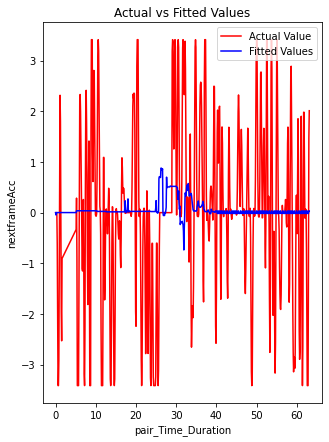

In [19]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F1["pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

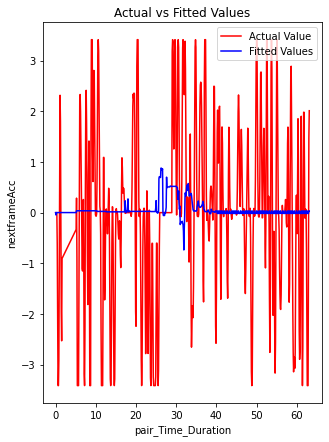

In [20]:
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F1["pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [21]:
ngsim.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_X', 'Local_Y',
       'Global_X', 'Global_Y', 'v_length', 'v_Class', 'v_Vel', 'v_Acc',
       'Lane_ID', 'Preceding', 'Space_Headway', 'Time_Headway', 'Location',
       'Preceding_Vehicle_Class', 'Rear_to_Front_Space_Headway',
       'Front_To_Rear_Time_Headway', 'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'v_Class_Name', 'Relative_Time', 'Vehicle_combination',
       'preceding_vehicle_length', 'lane_changes', 'Prec_Vehicle_ID',
       'previous_Vehicle_Velocity', 'previous_Vehicle_Acceleration',
       'previous_car_lane_changes', 'pair_Time_Duration',
       'total_pair_duration', 'nextframeAcc', 'nextframesvel',
       'nextframeposition', 'Vehicle_combination_cat'],
      dtype='object')